 # Data Science Unit 2 Sprint Challenge 4 — Model Validation

Follow the instructions for each numbered part to earn a score of 2. See the bottom of the notebook for a list of ways you can earn a score of 3.

## Predicting Blood Donations

Our dataset is from a mobile blood donation vehicle in Taiwan. The Blood Transfusion Service Center drives to different universities and collects blood as part of a blood drive.

The goal is to predict the last column, whether the donor made a donation in March 2007, using information about each donor's history. We'll measure success using recall score as the model evaluation metric.

Good data-driven systems for tracking and predicting donations and supply needs can improve the entire supply chain, making sure that more patients get the blood transfusions they need.

#### Run this cell to load the data:

In [1]:
import pandas as pd

df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/blood-transfusion/transfusion.data')

df = df.rename(columns={
    'Recency (months)': 'months_since_last_donation', 
    'Frequency (times)': 'number_of_donations', 
    'Monetary (c.c. blood)': 'total_volume_donated', 
    'Time (months)': 'months_since_first_donation', 
    'whether he/she donated blood in March 2007': 'made_donation_in_march_2007'
})

In [2]:
df.head()

,months_since_last_donation,number_of_donations,total_volume_donated,months_since_first_donation,made_donation_in_march_2007
0,2,50,12500,98,1
1,0,13,3250,28,1
2,1,16,4000,35,1
3,2,20,5000,45,1
4,1,24,6000,77,0


## Part 1.1 — Begin with baselines

What **accuracy score** would you get here with a **"majority class baseline"?** 
 
(You don't need to split the data into train and test sets yet. You can answer this question either with a scikit-learn function or with a pandas function.)

In [3]:
import numpy as np
from sklearn.metrics import accuracy_score

X = df.drop(columns='made_donation_in_march_2007')
y = df['made_donation_in_march_2007']
majority_class = y.mode()[0]
y_pred = np.full(shape=y.shape, fill_value=majority_class)

print('Majority Class Baseline Accuracy:', accuracy_score(y,y_pred))

Majority Class Baseline Accuracy: 0.7620320855614974


What **recall score** would you get here with a **majority class baseline?**

(You can answer this question either with a scikit-learn function or with no code, just your understanding of recall.)

In [4]:
from sklearn.metrics import recall_score

print('Majority Class Baseline Recall:', recall_score(y,y_pred))

Majority Class Baseline Recall: 0.0


## Part 1.2 — Split data

In this Sprint Challenge, you will use "Cross-Validation with Independent Test Set" for your model evaluation protocol.

First, **split the data into `X_train, X_test, y_train, y_test`**, with random shuffle. (You can include 75% of the data in the train set, and hold out 25% for the test set.)


In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size=0.75, test_size=0.25, random_state=None, shuffle=True)
    
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((561, 4), (187, 4), (561,), (187,))

In [6]:
import statsmodels.api as sm
model = sm.OLS(y_train, sm.add_constant(X_train))
print(model.fit().summary())

                                 OLS Regression Results                                
Dep. Variable:     made_donation_in_march_2007   R-squared:                       0.129
Model:                                     OLS   Adj. R-squared:                  0.124
Method:                          Least Squares   F-statistic:                     27.48
Date:                         Fri, 01 Feb 2019   Prob (F-statistic):           1.38e-16
Time:                                 10:56:32   Log-Likelihood:                -280.53
No. Observations:                          561   AIC:                             569.1
Df Residuals:                              557   BIC:                             586.4
Df Model:                                    3                                         
Covariance Type:                     nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
------------------------

In [8]:
from sklearn.preprocessing import PolynomialFeatures

for degree in [0, 1, 2, 3]:
    features = PolynomialFeatures(degree).fit(X_train).get_feature_names(X_train.columns)
    print(f'{degree} degree polynomial has {len(features)} features')
    print(features)
    print('\n')

0 degree polynomial has 1 features
['1']


1 degree polynomial has 5 features
['1', 'months_since_last_donation', 'number_of_donations', 'total_volume_donated', 'months_since_first_donation']


2 degree polynomial has 15 features
['1', 'months_since_last_donation', 'number_of_donations', 'total_volume_donated', 'months_since_first_donation', 'months_since_last_donation^2', 'months_since_last_donation number_of_donations', 'months_since_last_donation total_volume_donated', 'months_since_last_donation months_since_first_donation', 'number_of_donations^2', 'number_of_donations total_volume_donated', 'number_of_donations months_since_first_donation', 'total_volume_donated^2', 'total_volume_donated months_since_first_donation', 'months_since_first_donation^2']


3 degree polynomial has 35 features
['1', 'months_since_last_donation', 'number_of_donations', 'total_volume_donated', 'months_since_first_donation', 'months_since_last_donation^2', 'months_since_last_donation number_of_donations', 

In [7]:
def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LogisticRegression(**kwargs))

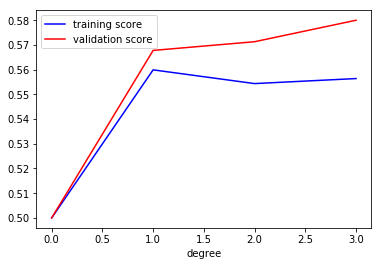

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import validation_curve
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

degree = [0, 1, 2, 3]
train_score, val_score = validation_curve(
    PolynomialRegression(), X_train, y_train,
    param_name='polynomialfeatures__degree', param_range=degree, 
    scoring='recall_macro', cv=3)

plt.plot(degree, np.median(train_score, 1), color='blue', label='training score')
plt.plot(degree, np.median(val_score, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.xlabel('degree');

#1st degree (original features have best validation score)

## Part 2.1 — Make a pipeline

Make a **pipeline** which includes:
- Preprocessing with any scikit-learn [**Scaler**](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing)
- Feature selection with **[`SelectKBest`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html)([`f_classif`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_classif.html))**
- Classification with [**`LogisticRegression`**](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

In [12]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import f_classif, SelectKBest
from sklearn.linear_model import LogisticRegression

pipe = make_pipeline(
    RobustScaler(), 
    SelectKBest(f_classif), 
    LogisticRegression()
)

## Part 2.2 — Do Grid Search Cross-Validation

Do [**GridSearchCV**](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) with your pipeline. Use **5 folds** and **recall score**.

Include these **parameters for your grid:**

#### `SelectKBest`
- `k : 1, 2, 3, 4`

#### `LogisticRegression`
- `class_weight : None, 'balanced'`
- `C : .0001, .001, .01, .1, 1.0, 10.0, 100.00, 1000.0, 10000.0`


**Fit** on the appropriate data.

In [14]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'selectkbest__k': [1,2,3,4], 
    'logisticregression__class_weight': [None,'balanced'],
    'logisticregression__C': [.0001, .001, .01, .1, 1.0, 10.0, 100.00, 1000.0, 10000.0]
}

gs = GridSearchCV(pipe,param_grid=param_grid, cv=5,
                 scoring='recall_macro')

gs.fit(X_train,y_train)

pd.DataFrame(gs.cv_results_).sort_values('rank_test_score')

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/anaconda3/lib/python3.7/si

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logisticregression__C,param_logisticregression__class_weight,param_selectkbest__k,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
31,0.001727,0.000092,0.000474,2.319929e-05,0.1,balanced,4,"{'logisticregression__C': 0.1, 'logisticregres...",0.617140,0.634205,...,0.679134,0.054888,1,0.692048,0.710003,0.682687,0.689245,0.646804,0.684157,0.020754
71,0.001669,0.000058,0.000443,5.794307e-06,10000,balanced,4,"{'logisticregression__C': 10000.0, 'logisticre...",0.629845,0.634205,...,0.678823,0.051817,2,0.706754,0.715638,0.689788,0.696345,0.666327,0.694970,0.016824
47,0.001676,0.000028,0.000453,7.240392e-06,10,balanced,4,"{'logisticregression__C': 10.0, 'logisticregre...",0.629845,0.634205,...,0.678823,0.051817,2,0.706754,0.715638,0.688321,0.696345,0.666327,0.694677,0.016924
55,0.001679,0.000064,0.000441,1.458841e-06,100,balanced,4,"{'logisticregression__C': 100.0, 'logisticregr...",0.629845,0.634205,...,0.678823,0.051817,2,0.706754,0.715638,0.689788,0.696345,0.666327,0.694970,0.016824
63,0.001718,0.000059,0.000509,1.294620e-04,1000,balanced,4,"{'logisticregression__C': 1000.0, 'logisticreg...",0.629845,0.634205,...,0.678823,0.051817,2,0.706754,0.715638,0.689788,0.696345,0.666327,0.694970,0.016824
39,0.001671,0.000023,0.000453,2.113922e-05,1,balanced,4,"{'logisticregression__C': 1.0, 'logisticregres...",0.629845,0.634205,...,0.676474,0.051613,6,0.703813,0.718801,0.685389,0.694879,0.666327,0.693842,0.017618
38,0.001656,0.000093,0.000453,2.351296e-05,1,balanced,3,"{'logisticregression__C': 1.0, 'logisticregres...",0.593885,0.640959,...,0.665925,0.057180,7,0.671242,0.678438,0.642324,0.670875,0.639934,0.660563,0.016113
68,0.001602,0.000028,0.000458,1.893326e-05,10000,balanced,1,"{'logisticregression__C': 10000.0, 'logisticre...",0.625108,0.635076,...,0.664646,0.059451,8,0.674619,0.672111,0.644795,0.682606,0.649424,0.664711,0.014856
52,0.001621,0.000051,0.000443,3.410636e-06,100,balanced,1,"{'logisticregression__C': 100.0, 'logisticregr...",0.625108,0.635076,...,0.664646,0.059451,8,0.674619,0.672111,0.644795,0.682606,0.649424,0.664711,0.014856
60,0.001569,0.000003,0.000442,4.452750e-06,1000,balanced,1,"{'logisticregression__C': 1000.0, 'logisticreg...",0.625108,0.635076,...,0.664646,0.059451,8,0.674619,0.672111,0.644795,0.682606,0.649424,0.664711,0.014856


## Part 3 — Show best score and parameters

Display your **best cross-validation score**, and the **best parameters** (the values of `k, class_weight, C`) from the grid search.

(You're not evaluated here on how good your score is, or which parameters you find. You're only evaluated on being able to display the information. There are several ways you can get the information, and any way is acceptable.)

In [15]:
print('Best score:',gs.best_score_)
print('Parameters for best score:', gs.best_params_)

Best score: 0.6791343691829194
Parameters for best score: {'logisticregression__C': 0.1, 'logisticregression__class_weight': 'balanced', 'selectkbest__k': 4}


In [16]:
# Which features were selected?
selector = gs.best_estimator_.named_steps['selectkbest']
all_names = X_train.columns
selected_mask = selector.get_support()
selected_names = all_names[selected_mask]
unselected_names = all_names[~selected_mask]

print('Features selected:')
for name in selected_names:
    print(name)

print()
print('Features not selected:')
for name in unselected_names:
    print(name)

Features selected:
months_since_last_donation
number_of_donations
total_volume_donated
months_since_first_donation

Features not selected:


In [18]:
#Testing model on Test data

test_score = gs.score(X_test, y_test)
print('Test Score:', test_score)

Test Score: 0.7088985788113695


## Part 4 — Calculate classification metrics from a confusion matrix

Suppose this is the confusion matrix for your binary classification model:

<table>
  <tr>
    <th colspan="2" rowspan="2"></th>
    <th colspan="2">Predicted</th>
  </tr>
  <tr>
    <th>Negative</th>
    <th>Positive</th>
  </tr>
  <tr>
    <th rowspan="2">Actual</th>
    <th>Negative</th>
    <td>85</td>
    <td>58</td>
  </tr>
  <tr>
    <th>Positive</th>
    <td>8</td>
    <td>36</td>
  </tr>
</table>

Calculate accuracy

In [ ]:
fn = 8
fp = 58
tn = 85
tp = 36

accuracy = (tp+tn)/(tp+tn+fp+fn)
print('Accuracy:',accuracy)

Calculate precision

In [ ]:
precision = tp / (tp+fp)
print('Precision:',precision)

Calculate recall

In [ ]:
recall = tp / (tp+fn)
print('Recall:', recall)

In [ ]:
f1 = (2*tp) / ((2*tp)+fp+fn)
print('F1 Score:',f1)

In [ ]:
fpr = fn / (fn+tp)
print('False Positive Rate:',fpr)

## BONUS — How you can earn a score of 3

### Part 1
Do feature engineering, to try improving your cross-validation score.

### Part 2
Add transformations in your pipeline and parameters in your grid, to try improving your cross-validation score.

### Part 3
Show names of selected features. Then do a final evaluation on the test set — what is the test score?

### Part 4
Calculate F1 score and False Positive Rate. 